In [71]:
import warnings
warnings.filterwarnings("ignore", message="Could not find the number of physical cores*")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Part 1: MNIST
## Section A - Visualization
### Understanding the Dataset

In [42]:
# Load the dataset
df_m = pd.read_csv("mnist.csv")

In [43]:
# Reduce memory usage by sampling and casting data
sample_df = df_m.sample(n=2000, random_state=42).copy()
pixel_columns = sample_df.columns.drop('label')
sample_df[pixel_columns] = sample_df[pixel_columns].astype(np.float32)

# Separate labels and features
labels = sample_df['label']
features = sample_df.drop(columns=['label'])

# Group by digit
digit_groups = {digit: sample_df[sample_df['label'] == digit] for digit in sorted(sample_df['label'].unique())}

# Redo visualizations on sample
figures = {}

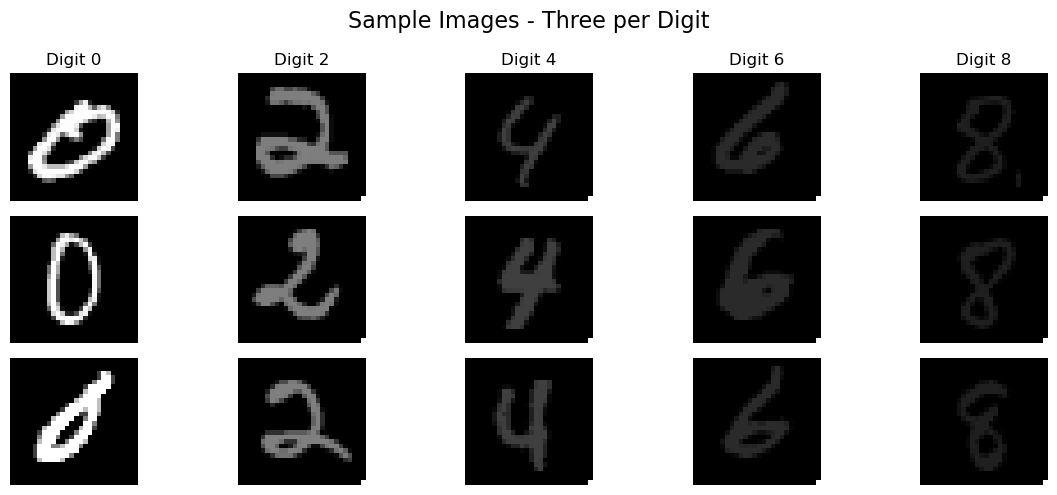

In [4]:
# Plot: Three sample images per digit
fig, axs = plt.subplots(3, 5, figsize=(12, 5))
fig.suptitle("Sample Images - Three per Digit", fontsize=16)

for i, digit in enumerate(sorted(digit_groups.keys())):
    samples = digit_groups[digit].iloc[:3, 1:].values
    for j in range(3):
        ax = axs[j, i]
        ax.imshow(samples[j].reshape(28, 28), cmap='gray')
        ax.axis('off')
        if j == 0:
            ax.set_title(f"Digit {digit}")

plt.tight_layout()
plt.show()


### Sample Images – Three per Digit

This grid displays three handwritten examples for each digit class (0, 2, 4, 6, 8), using `imshow()` to visualize the original 28×28 pixel images. This plot serves as a visual sanity check and helps us observe the natural variability within each class. Notably, digits like "2" show significant stylistic differences, while digits like "8" have consistent structure. These observations justify why machine learning models need to be robust to variation in handwriting.

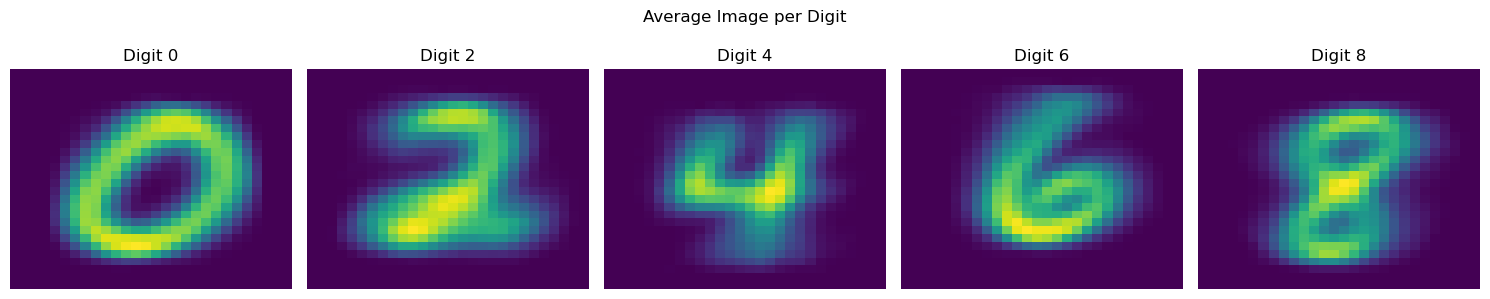

In [5]:
# Heatmaps: Average image per digit
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, digit in enumerate(sorted(digit_groups.keys())):
    avg_digit = digit_groups[digit].drop(columns='label').mean().values.reshape(28, 28)
    sns.heatmap(avg_digit, ax=axs[i], cbar=False, cmap='viridis')
    axs[i].set_title(f"Digit {digit}")
    axs[i].axis('off')

fig.suptitle("Average Image per Digit")
plt.tight_layout()
plt.show()

### Average Image per Digit

Each heatmap shows the average pixel intensity for all samples of a given digit class. These serve as “digit templates” and help highlight which regions (pixels) are most active per class. For example, digit "0" activates a circular stroke, while "4" has a clear vertical and horizontal segment. These structural differences are useful for PCA, feature selection, and model interpretability.

In [15]:
pixel_data = df_m[pixel_columns].astype(np.float32)

# Compute standard deviation for each pixel
pixel_std = pixel_data.std()

# Find the maximum std value
max_std_value = pixel_std.max()

# Find all pixel(s) with this exact max std value
most_variable_pixels = pixel_std[pixel_std == max_std_value]

# Display results
print("Most variable pixel(s):")
print(most_variable_pixels)

Most variable pixel(s):
px_406    0.444441
dtype: float32


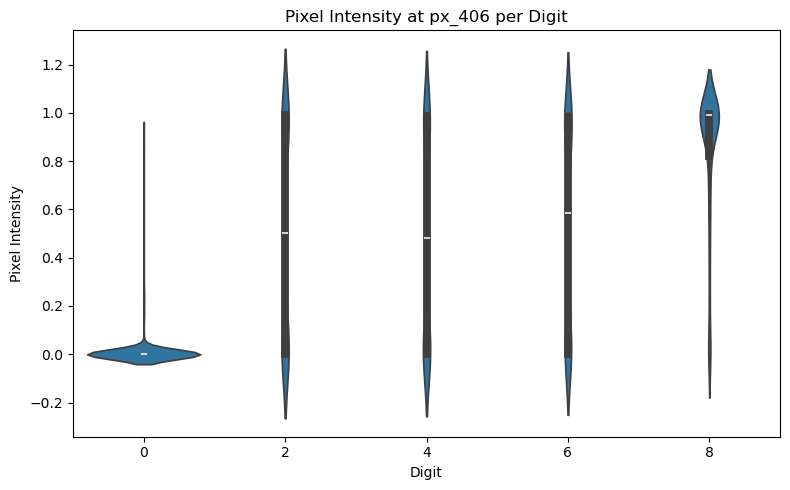

In [6]:
center_pixel = 'px_406'

# Plot: Violin plot of a single pixel value across digits
fig, ax = plt.subplots(figsize=(8, 5))
sns.violinplot(data=sample_df, x='label', y=center_pixel, ax=ax)
ax.set_title(f"Pixel Intensity at {center_pixel} per Digit")
ax.set_xlabel("Digit")
ax.set_ylabel("Pixel Intensity")

plt.tight_layout()
plt.show()

### Violin Plot – Pixel Intensity at `px_406` per Digit

This violin plot shows the distribution of intensity values for the most variable pixel (`px_406`) across all digit classes. It clearly shows that this pixel is strongly activated in digits 2, 4, 6, and 8, but rarely in digit 0. This suggests that the presence or absence of activation at this pixel is a highly discriminative feature, and justifies its use in feature selection or model input.

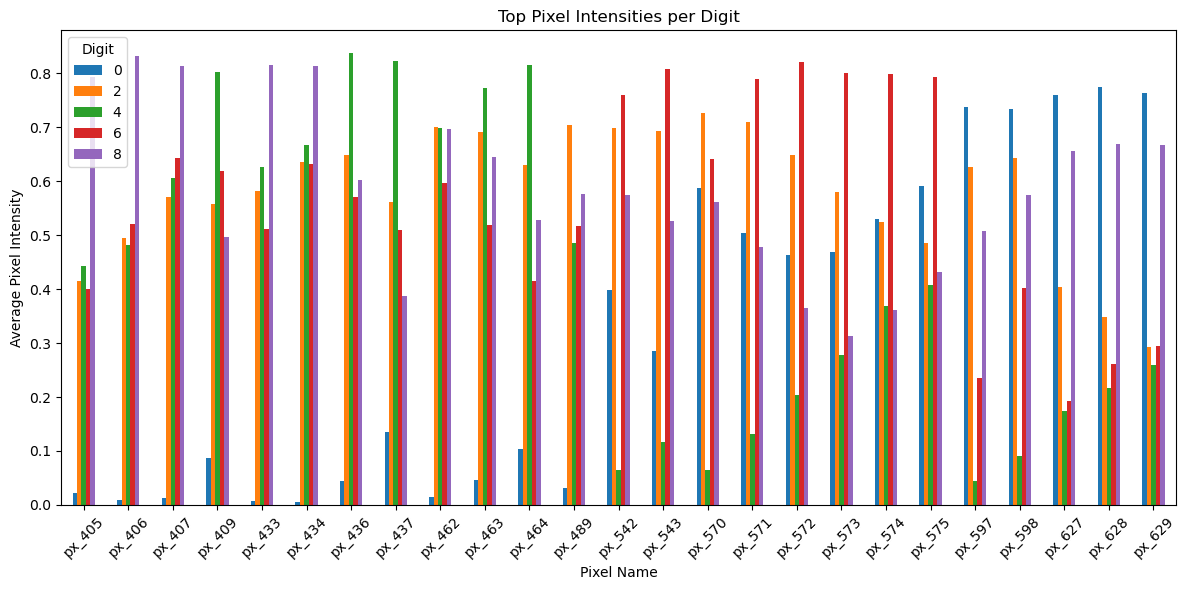

In [18]:
# Average pixel intensity per digit
avg_per_digit = sample_df.groupby('label')[pixel_columns].mean()

# Top 5 pixels per digit
top5_per_digit = {
    digit: avg_per_digit.loc[digit].sort_values(ascending=False).head(5)
    for digit in avg_per_digit.index
}

# Collect all unique top pixels across all digits
shared_top_pixels = sorted(set(p for top in top5_per_digit.values() for p in top.index))

# Build a DataFrame for the grouped bar plot
grouped_data = avg_per_digit[shared_top_pixels].T  # rows: pixel, columns: digit

# Plot grouped bar chart
grouped_data.plot(kind="bar", figsize=(12, 6))
plt.title("Top Pixel Intensities per Digit")
plt.xlabel("Pixel Name")
plt.ylabel("Average Pixel Intensity")
plt.xticks(rotation=45)
plt.legend(title="Digit")
plt.tight_layout()
plt.show()

### Grouped Bar Chart – Top 5 Used Pixels per Digit

This grouped bar chart shows the average intensity of the top 5 most-used pixels for each digit class. Each bar group represents one pixel, with color-coded bars for each digit. This helps identify which pixels are unique to specific digits and which are shared. For example, pixels that are highly active only in digit 4 may become strong features for distinguishing it from others.

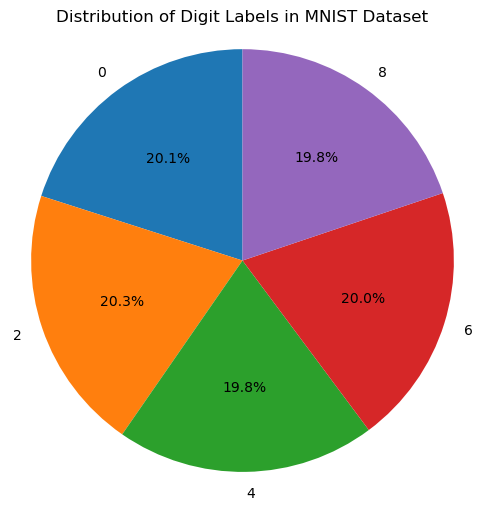

In [17]:
# Count samples per label
label_counts = df_m['label'].value_counts().sort_index()

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab10.colors)
plt.title("Distribution of Digit Labels in MNIST Dataset")
plt.axis('equal')  # Equal aspect ratio to make it circular
plt.show()

### Pie Chart – Digit Label Distribution

This pie chart shows the proportion of each digit class in the dataset. The distribution is nearly uniform (≈20% per class), which is ideal for classification tasks. It ensures that models won’t be biased due to class imbalance and that evaluation metrics will be reliable.

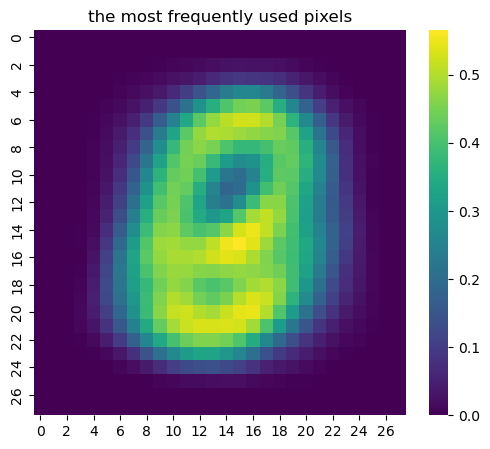

In [9]:
# Heatmap: Average image over all samples
avg_all = features.mean().values.reshape(28, 28)

plt.figure(figsize=(6, 5))
sns.heatmap(avg_all, cmap='viridis')
plt.title("the most frequently used pixels")
plt.show()

### observation: 


This 28×28 heatmap shows the average pixel value at each position across all digit images in the dataset. Brighter regions indicate pixels that are frequently active (i.e., where strokes often appear), while darker regions represent pixels that are rarely used.

Each pixel is the mean of that position across **all samples**, regardless of label — this plot does not distinguish between different digits (0, 2, 4, 6, 8).

**Axes Explanation:**
- The **x-axis** represents the column index (from 0 to 27) of each pixel in the image.
- The **y-axis** represents the row index (from 0 to 27).
- Together, each (x, y) coordinate maps to a specific pixel in the original 28×28 image grid — for example, (0, 0) is the top-left pixel, and (27, 27) is the bottom-right.

**Purpose and Importance:**
- Helps identify the most "popular" or frequently activated pixels in the dataset.
- Highlights which areas are generally important across all digits.
- Reveals low-activity areas (such as the corners) which may be dropped during feature selection.
- Useful for guiding PCA and dimensionality reduction decisions.

The most active pixel zones form a bright vertical oval centered in the image, which reflects structural overlap among digits like “0”, “6”, and especially “8”. Border pixels are consistently dark, suggesting they contribute little useful signal.


## Section B - Classification
### Section B.1 - Feature Engineering
first we need to do some feature engineering to minimize noise and maximize correctness and clarity

In [49]:
# Reload the dataset
df_m0 = pd.read_csv("mnist.csv")

In [50]:
# Check for missing values
print("Missing Values Count:")
df_m0.isnull().sum()

Missing Values Count:


px_0      0
px_1      0
px_2      0
px_3      0
px_4      0
         ..
px_780    0
px_781    0
px_782    0
px_783    0
label     0
Length: 785, dtype: int64

In [52]:
df_m0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34418 entries, 0 to 34417
Columns: 785 entries, px_0 to label
dtypes: float64(784), int64(1)
memory usage: 206.1 MB


In [53]:
pixel_columns = df_m0.columns.drop('label')

df_m0['total_intensity'] = df_m0[pixel_columns].sum(axis=1)
df_m0['nonzero_count'] = (df_m0[pixel_columns] > 0).sum(axis=1)

In [54]:
# Check for any columns that have only a single unique value
useless_cols = [col for col in df_m0.columns if df_m0[col].nunique() <= 1]
print(useless_cols)

['px_0', 'px_1', 'px_2', 'px_3', 'px_4', 'px_5', 'px_6', 'px_7', 'px_8', 'px_9', 'px_10', 'px_11', 'px_16', 'px_17', 'px_18', 'px_19', 'px_20', 'px_21', 'px_22', 'px_23', 'px_24', 'px_25', 'px_26', 'px_27', 'px_28', 'px_29', 'px_30', 'px_31', 'px_52', 'px_53', 'px_54', 'px_55', 'px_56', 'px_57', 'px_82', 'px_83', 'px_84', 'px_85', 'px_111', 'px_112', 'px_113', 'px_140', 'px_141', 'px_168', 'px_169', 'px_196', 'px_197', 'px_252', 'px_280', 'px_308', 'px_336', 'px_364', 'px_392', 'px_420', 'px_448', 'px_476', 'px_477', 'px_504', 'px_532', 'px_560', 'px_587', 'px_588', 'px_616', 'px_617', 'px_644', 'px_645', 'px_671', 'px_672', 'px_673', 'px_674', 'px_699', 'px_700', 'px_701', 'px_702', 'px_703', 'px_727', 'px_728', 'px_729', 'px_730', 'px_731', 'px_753', 'px_754', 'px_755', 'px_756', 'px_757', 'px_758', 'px_759', 'px_760', 'px_761', 'px_762', 'px_763', 'px_764', 'px_765', 'px_766', 'px_767', 'px_768', 'px_769', 'px_770', 'px_771', 'px_772', 'px_773', 'px_774', 'px_775', 'px_776', 'px_777

In [55]:
df_m0.drop(columns=useless_cols, inplace=True)

In [58]:
print('Data Cleaning Completed\n')
df_m0.info()

Data Cleaning Completed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34418 entries, 0 to 34417
Columns: 676 entries, px_12 to nonzero_count
dtypes: float64(674), int64(2)
memory usage: 177.5 MB


In [60]:
df_m0.describe().T.sort_values('std', ascending=False)

,count,mean,std,min,25%,50%,75%,max
nonzero_count,34418.0,1.668358e+02,36.079985,61.000000,141.000000,165.000000,191.000000,351.000000
total_intensity,34418.0,1.149366e+02,32.545353,25.854902,91.388236,112.013726,135.380393,311.698035
label,34418.0,3.984311e+00,2.827233,0.000000,2.000000,4.000000,6.000000,8.000000
px_406,34418.0,4.572015e-01,0.444460,0.000000,0.000000,0.356863,0.988235,1.000000
px_433,34418.0,5.114889e-01,0.443807,0.000000,0.000000,0.576471,0.992157,1.000000
...,...,...,...,...,...,...,...,...
px_749,34418.0,2.392729e-06,0.000444,0.000000,0.000000,0.000000,0.000000,0.082353
px_32,34418.0,1.823032e-06,0.000338,0.000000,0.000000,0.000000,0.000000,0.062745
px_15,34418.0,1.025455e-06,0.000190,0.000000,0.000000,0.000000,0.000000,0.035294
px_421,34418.0,6.836368e-07,0.000127,0.000000,0.000000,0.000000,0.000000,0.023529


### Full Data Cleaning and Preprocessing Summary

This section describes the preprocessing pipeline applied to the raw `mnist.csv` dataset to prepare it for model training and evaluation. The goal was to eliminate irrelevant features, enhance signal through feature engineering, and confirm dataset integrity prior to classification with Random Forest and MLP.

#### 1. Missing Value Check

We confirmed that the dataset contains no missing values using `df.isnull().sum()`. All 784 pixel features and the label column are complete. No imputation was necessary.

#### 2. Feature Engineering and Imputation

We introduced two global image-level features based on domain knowledge of handwriting structure:

- `total_intensity`: Sum of all pixel values per image. Serves as a proxy for overall brightness or ink density, which helps distinguish digits with thicker strokes (e.g., "8") from lighter ones (e.g., "4").
- `nonzero_count`: Number of non-zero pixels per image. Captures stroke length and shape density regardless of brightness, providing structural information complementary to `total_intensity`.

These features are numeric, interpretable, and expected to improve model performance, particularly in tree-based models.

#### 3. Redundant Feature Removal

We identified and dropped 111 columns with only a single unique value (typically all-zero pixels). These features carried no information for classification and were removed to reduce dimensionality and noise.

#### 4. Final Dataset Verification
- All features remaining are numeric (float32 or int64)

- No missing values or constant columns remain

- Dataset size is unchanged: 34,418 samples × 675+ meaningful features (after dropping 111 and adding 2)

- The dataset is now suitable for scaling, PCA (Section C), and model training (Section B) using Random Forest, MLPClassifier, and other supervised learning methods

### Section B.2.1 - Setup and Data Preparation

In this section, we prepare the dataset for modeling. We define the features (X) and target (y),
split the data into train, validation, and test sets using an 80/10/10 split, as required by the assignment.

In [72]:
# Features and target
X_m = df_m0.drop(columns=['label'])
y_m = df_m0['label']

# Split: 80/10/10
X_m_train, X_m_temp, y_m_train, y_m_temp = train_test_split(X_m, y_m, test_size=0.2, stratify=y_m, random_state=42)
X_m_val, X_m_test, y_m_val, y_m_test = train_test_split(X_m_temp, y_m_temp, test_size=0.5, stratify=y_temp, random_state=42)

### B.2.2 - Model: Random Forest
We train a Random Forest classifier using GridSearchCV to tune n_estimators, max_depth, and apply class_weight='balanced' for handling class imbalance. Evaluation is based on Macro F1 to ensure fairness to both classes.

In [ ]:
rf_params = {'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42),rf_params,scoring='f1_macro', cv=3,n_jobs=-1, verbose=0)

start_train = time.time()
rf_grid.fit(X_m_train, y_m_train)
end_train = time.time()
rf_train_time = end_train - start_train


start_pred = time.time()
rf_preds = rf_grid.predict(X_m_test)
end_pred = time.time()
rf_pred_time = end_pred - start_pred

rf_accuracy = accuracy_score(y_m_test, rf_preds)
rf_f1 = f1_score(y_m_test, rf_preds, average='macro')

rf_results = {
    'best_params': rf_grid.best_params_,
    'train_time_sec': rf_train_time,
    'predict_time_sec': rf_pred_time,
    'accuracy': rf_accuracy,
    'f1_macro': rf_f1
}

tools.display_dataframe_to_user(name="Random Forest Results", dataframe=pd.DataFrame([rf_results]))

In [66]:
rf_best = rf_gs.best_estimator_
y_m_val_pred_rf = rf_best.predict(X_m_val)
y_m_test_pred_rf = rf_best.predict(X_m_test)

NameError: name 'rf_gs' is not defined

### B.2 - Model: Neural Networks (MLP)

We next train a Neural Network classifier using a Multi-Layer Perceptron (MLP).
We tune the number of hidden layers and neurons (hidden_layer_sizes), the activation function, regularization strength (alpha), and the learning rate strategy.
Neural networks are well-suited for learning complex nonlinear patterns, particularly when features are properly scaled. We use GridSearchCV with 3-fold cross-validation and f1_macro to select the best-performing architecture.